In [ ]:
import torch
import torch.nn as nn  # All neural network modules
import torch.optim as optim # For optimizers like SGD
from torch.utils.data import TensorDataset, random_split, DataLoader  # Gives easier dataset managment
import torchvision
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
import matplotlib.pyplot as plt
import numpy as np

In [90]:
# use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In this demo code, we use CIFAR-10 dataset to illustrate how to construct and train a CNN. We first construct a simple CNN as a toy model, then we use a pretrained ResNet model on CIFAR-10. 

# CIFAR-10 dataset


In [ ]:
# Define how we transform the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load the CItorch.nn.functionalAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                            download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [99]:
# construct data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True, # speeds up GPU transfers
                                           num_workers=4) # allows asynchronous data transfers
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=True, 
                                          num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


['frog', 'truck', 'bird', 'car']


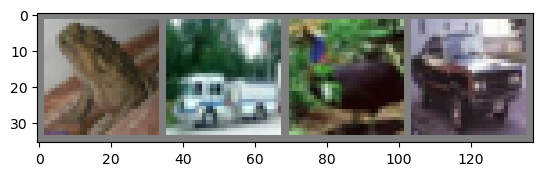

In [60]:
# visualize some samples
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    
image_iter = iter(train_loader)
images, label_idx = next(image_iter)
imshow(torchvision.utils.make_grid(images[:4]))
# labels
label_idx = label_idx[:4]
print([classes[idx] for idx in label_idx])

# Define the model architecture

In [6]:
# Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # feature extraction (convolutional and pooling layers)
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # first convolutional layer
            nn.ReLU(), # activation function
            nn.MaxPool2d(kernel_size=2, stride=2), # maximum pooling layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # second convolutional layer
            nn.ReLU(), # activation function
            nn.MaxPool2d(kernel_size=2, stride=2) # maximum pooling layer 
        )
        # fully connected layers (classifier)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512), # Flattened 64 feature maps of size 8x8 into a single vector
            nn.ReLU(), # activation function
            nn.Dropout(0.5), # dropout probability of the first layer in FCNN
            nn.Linear(512, 10) # output layer with 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the output from (batch_size, 64, 8, 8) → (batch_size, 64 * 8 * 8)
        x = self.classifier(x)
        return x


In [ ]:
# construct the CNN, loss function and optimizer
simple_cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(simple_cnn.parameters(), lr=0.001)

# Training

In [119]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=10):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_val_acc = 0.0
    patience = 10
    no_improve = 0
    for epoch in range(num_epochs):
        # Training phase
        model.train() # set the model at training status
        epoch_train_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:      
            inputs = inputs.to(device)
            labels = labels.to(device)  
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss_one = epoch_train_loss/len(train_loader)
        train_acc_one = 100 * correct / total

        # Validation phase
        model.eval() # set the model at evaluation status
        epoch_val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                epoch_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss_one = epoch_val_loss/len(test_loader)
        val_acc_one = 100 * correct / total

        if scheduler is not None:
            scheduler.step(val_loss_one)

        print(f'Epoch {epoch+1}: '
            f'Train Loss: {train_loss_one:.4f}, Val Loss: {val_loss_one:.4f} | '
            f'Train Acc: {train_acc_one:.2f}%, Val Acc: {val_acc_one:.2f}%')
        
        train_loss.append(train_loss_one)
        val_loss.append(val_loss_one)
        train_acc.append(train_acc_one)
        val_acc.append(val_acc_one)

        if val_acc_one > best_val_acc:
            best_val_acc = val_acc_one
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping")
                break
        
        
    return train_loss, val_loss, train_acc, val_acc
    


In [105]:
num_params = sum(p.numel() for p in simple_cnn.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Number of trainable parameters: 2122186


In [11]:
print("Training Simple CNN:")
cnn_train_loss, cnn_val_loss, cnn_train_acc, cnn_val_acc = train_model(simple_cnn, criterion, optimizer, num_epochs=100)

Training Simple CNN:
Epoch 1: Train Loss: 2.2900, Val Loss: 2.2839 | Train Acc: 16.05%, Val Acc: 20.96%
Epoch 2: Train Loss: 2.2787, Val Loss: 2.2708 | Train Acc: 19.45%, Val Acc: 24.59%
Epoch 3: Train Loss: 2.2640, Val Loss: 2.2527 | Train Acc: 21.71%, Val Acc: 26.00%
Epoch 4: Train Loss: 2.2428, Val Loss: 2.2264 | Train Acc: 23.33%, Val Acc: 26.57%
Epoch 5: Train Loss: 2.2131, Val Loss: 2.1902 | Train Acc: 24.04%, Val Acc: 26.80%
Epoch 6: Train Loss: 2.1758, Val Loss: 2.1467 | Train Acc: 24.69%, Val Acc: 26.94%
Epoch 7: Train Loss: 2.1360, Val Loss: 2.1030 | Train Acc: 25.23%, Val Acc: 27.72%
Epoch 8: Train Loss: 2.0994, Val Loss: 2.0637 | Train Acc: 26.25%, Val Acc: 28.39%
Epoch 9: Train Loss: 2.0672, Val Loss: 2.0288 | Train Acc: 27.20%, Val Acc: 29.27%
Epoch 10: Train Loss: 2.0361, Val Loss: 1.9969 | Train Acc: 28.02%, Val Acc: 30.41%
Epoch 11: Train Loss: 2.0077, Val Loss: 1.9665 | Train Acc: 28.95%, Val Acc: 30.95%
Epoch 12: Train Loss: 1.9798, Val Loss: 1.9375 | Train Acc: 29.7

# A deeper CNN
Since CIFAR10 is a relatively small dataset, we need to apply some techniques to avoid overfitting. 

In [132]:
# use more complex data transformation before training
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# read training dataset
dataset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

# construct dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=8)

# read testing dataset and construct dataloader
test_set = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
   

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class deepCNN(nn.Module):
    def __init__(self):
        super(deepCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
        self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)

        # Pooling layer (reduces spatial dimensions by half)
        self.pool = nn.MaxPool2d(2, 2)

        # Batch normalization for convolutional layers
        self.bn_conv1 = nn.BatchNorm2d(128)
        self.bn_conv2 = nn.BatchNorm2d(128)
        self.bn_conv3 = nn.BatchNorm2d(256)
        self.bn_conv4 = nn.BatchNorm2d(256)

        # Batch normalization for fully connected layers
        self.bn_dense1 = nn.BatchNorm1d(1024)
        self.bn_dense2 = nn.BatchNorm1d(512)

        # Dropout for regularization
        self.dropout_conv = nn.Dropout2d(p=0.25)
        self.dropout = nn.Dropout(p=0.5)

        # Fully connected (dense) layers
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    # Forward pass through convolutional layers with ReLU, batch norm, pooling, and dropout
    def conv_layers(self, x):
        out = F.relu(self.bn_conv1(self.conv1(x)))
        out = F.relu(self.bn_conv2(self.conv2(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)
        out = F.relu(self.bn_conv3(self.conv3(out)))
        out = F.relu(self.bn_conv4(self.conv4(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)
        return out
    
    # Forward pass through fully connected layers with ReLU, batch norm, and dropout
    def dense_layers(self, x):
        out = F.relu(self.bn_dense1(self.fc1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn_dense2(self.fc2(out)))
        out = self.dropout(out)
        out = self.fc3(out)  # Final output layer (no activation for logits)
        return out

    # Complete forward pass
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(-1, 256 * 8 * 8)  # Flatten before dense layers
        out = self.dense_layers(out)
        return out

# Model instantiation
deep_cnn = deepCNN().to(device)

# Calculate and print the number of trainable parameters
num_params = sum(p.numel() for p in deep_cnn.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy for multi-class classification
optimizer = optim.Adam(deep_cnn.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Learning rate scheduler to reduce LR on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

# Lists to store training/validation loss and accuracy history
loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

# Training loop for 140 epochs
for epoch in range(140):
    running_loss = 0.0
    correct = 0
    for data in train_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = deep_cnn(batch)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        # Compute training statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    # Average training loss and accuracy
    avg_loss = running_loss / len(train_set)
    avg_acc = correct / len(train_set) * 100
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # Validation statistics
    deep_cnn.eval()  # Set model to evaluation mode
    with torch.no_grad():
        loss_val = 0.0
        correct_val = 0
        for data in val_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = deep_cnn(batch)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            loss_val += loss.item()
        avg_loss_val = loss_val / len(val_set)
        avg_acc_val = correct_val / len(val_set) * 100
        loss_hist_val.append(avg_loss_val)
        acc_hist_val.append(avg_acc_val)
    deep_cnn.train()  # Back to training mode

    # Adjust learning rate based on validation loss
    scheduler.step(avg_loss_val)
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {avg_loss:.4f}, Val Loss: {avg_loss_val:.4f} | '
          f'Train Acc: {avg_acc:.2f}%, Val Acc: {avg_acc_val:.2f}%')


# Comparison between simple CNN and deep CNN

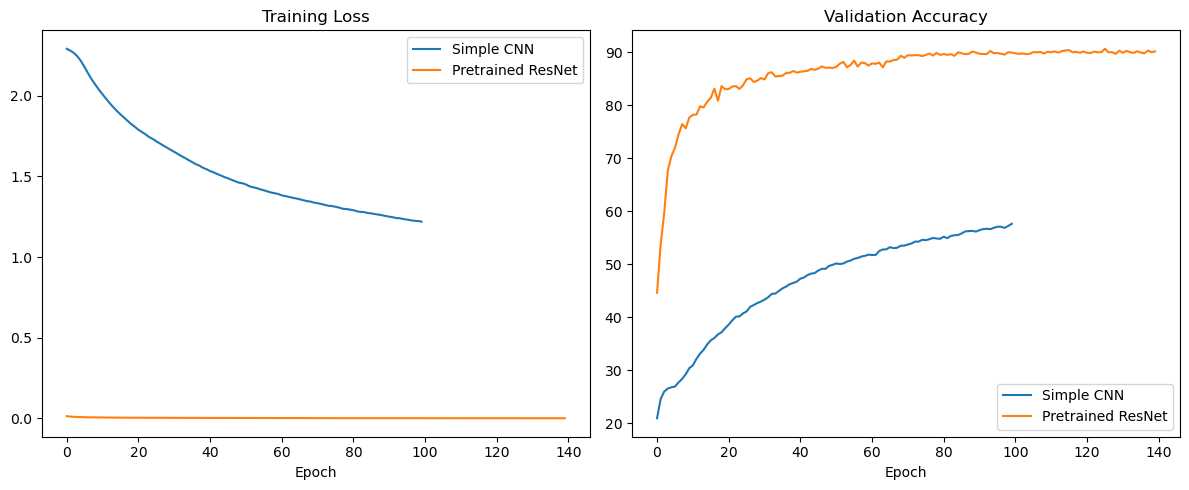

In [142]:
# comparison between simple CNN and pretrained ResNet-18
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_train_loss, label='Simple CNN')
plt.plot(loss_hist, label='Pretrained ResNet')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_val_acc, label='Simple CNN')
plt.plot(acc_hist_val, label='Pretrained ResNet')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [144]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print(f"\nFinal Test Accuracy:")
print(f"Simple CNN: {evaluate_model(simple_cnn, test_loader):.2f}%")
print(f"Pretrained ResNet: {evaluate_model(deep_cnn, test_loader):.2f}%")


Final Test Accuracy:
Simple CNN: 57.65%
Pretrained ResNet: 91.14%


GroundTruth: 
   cat  ship  ship plane
Predicted by simple CNN: 
   cat   car  ship  ship
Predicted by deep CNN: 
   cat  ship  ship plane


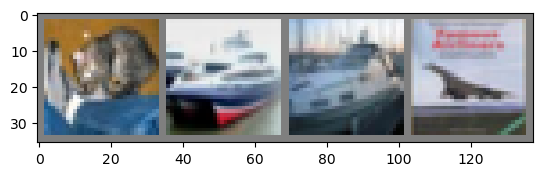

In [154]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
# True labels
print('GroundTruth: \n', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# prediction from simple CNN
outputs = simple_cnn(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted by simple CNN: \n', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
# prediction from pretrained ResNet
outputs = deep_cnn(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted by deep CNN: \n', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Reference

https://github.com/GeekAlexis/cifar10-cnn/blob/master/CIFAR_10_CNN.ipynb